Download Data

In [1]:
#Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from pathlib import Path
import shutil
import kagglehub
from tqdm import tqdm


c:\Users\mario\miniconda3\envs\dsmml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h1> Download Datasets

Wir laden die beiden Datasets 
- https://www.kaggle.com/datasets/mstjebashazida/affectnet/data
- https://www.kaggle.com/datasets/msambare/fer2013?resource=download

runter und speichern sie im Ordner Raw Data.
Da hier 60k Bilder geladen werden, dauert es etwas.

In [ ]:
import os
import shutil
import zipfile
from tqdm import tqdm
import kagglehub


# =========================================================
# Pfade
# =========================================================

RAW_DATA = "../Raw Data"   # liegt neben deinem Preprocessing-Ordner

AFFECTNET_FOLDER = os.path.join(RAW_DATA, "AffectNet")
FER_FOLDER       = os.path.join(RAW_DATA, "FER-2013")


# =========================================================
# Ordner sicher löschen (Windows-kompatibel)
# =========================================================

def reset_folder(path: str):
    """Löscht einen Ordner komplett und legt ihn neu an (Windows-fix)."""

    def remove_readonly(func, path, _):
        os.chmod(path, 0o777)
        func(path)

    if os.path.exists(path):
        shutil.rmtree(path, onerror=remove_readonly)

    os.makedirs(path, exist_ok=True)


# =========================================================
# Hilfsfunktionen
# =========================================================

def find_root_with_subdirs(base_dir: str, required_subdirs):
    """
    Durchsucht rekursiv base_dir und gibt den ersten Ordner zurück,
    der alle required_subdirs enthält (z.B. ["Train","Test"] oder ["train","test"])
    """
    required_subdirs = set(required_subdirs)
    for root, dirs, files in os.walk(base_dir):
        if required_subdirs.issubset(set(dirs)):
            return root
    return None


def copy_with_progress(src_root: str, dst_root: str, desc: str = "Copying"):
    """
    Kopiert alle Dateien rekursiv von src_root nach dst_root.
    Zeigt eine Progress-Bar.
    """

    file_list = []
    for root, dirs, files in os.walk(src_root):
        for f in files:
            src_path = os.path.join(root, f)
            rel_path = os.path.relpath(src_path, src_root)
            file_list.append((src_path, rel_path))

    for src_path, rel_path in tqdm(file_list, desc=desc, unit="file"):
        dst_path = os.path.join(dst_root, rel_path)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy2(src_path, dst_path)


# =========================================================
# 1. AFFECTNET
# =========================================================

print("📥 Downloading AffectNet via kagglehub...")
affectnet_dl_path = kagglehub.dataset_download("mstjebashazida/affectnet")
print("AffectNet downloaded to:", affectnet_dl_path)

affectnet_src_root = find_root_with_subdirs(affectnet_dl_path, ["Train", "Test"])
if affectnet_src_root is None:
    raise RuntimeError("❌ Konnte keinen AffectNet-Ordner mit 'Train' + 'Test' finden!")

print("🔁 Resetting target folder:", AFFECTNET_FOLDER)
reset_folder(AFFECTNET_FOLDER)

print("📂 Copying AffectNet into Raw Data/AffectNet ...")
copy_with_progress(affectnet_src_root, AFFECTNET_FOLDER, desc="AffectNet")


# =========================================================
# 2. FER-2013
# =========================================================

print("\n📥 Downloading FER-2013 via kagglehub...")
fer_dl_path = kagglehub.dataset_download("msambare/fer2013")
print("FER-2013 downloaded to:", fer_dl_path)

fer_src_root = find_root_with_subdirs(fer_dl_path, ["train", "test"])
if fer_src_root is None:
    raise RuntimeError("❌ Konnte keinen FER-2013-Ordner mit 'train' + 'test' finden!")

print("🔁 Resetting target folder:", FER_FOLDER)
reset_folder(FER_FOLDER)

print("📂 Copying FER-2013 into Raw Data/FER-2013 ...")
copy_with_progress(fer_src_root, FER_FOLDER, desc="FER-2013")


print("\n✅ All datasets downloaded and copied into 'Raw Data' successfully.")


<h1> Raw Data analysieren

Im ersten Schritt analysieren wir die beiden Datasets.
Wir betrachten
- Anzahl an Bilder pro Klasse
- Pixel pro Bild
- Beispielbilder pro Klasse
- Durchschnittliche Helligkeit pro Klasse

<h2> FER-2013 Dataset analysieren

In [3]:
DATASET_ROOT = "../Raw Data/FER-2013"
EMOTIONS = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
SPLITS = ["train", "test"]

<h3> Anzahl der Bilder pro Klasse

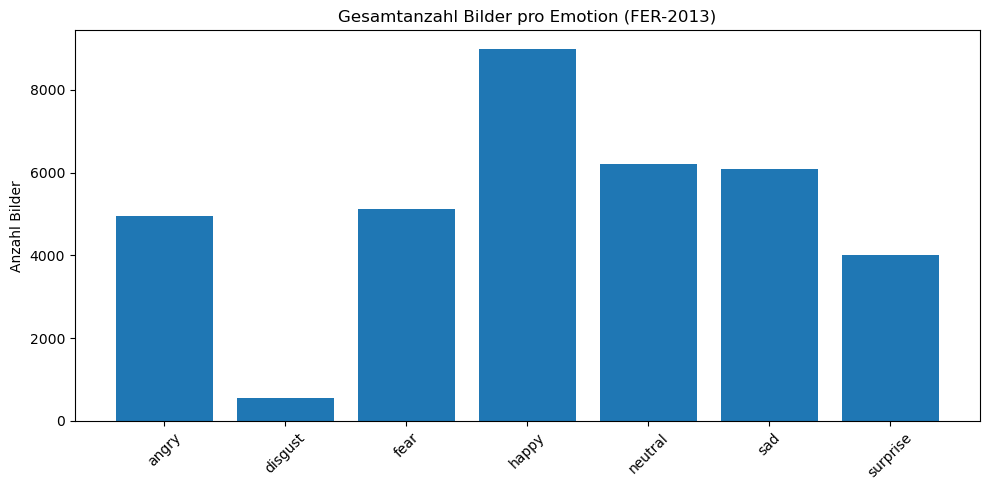

In [ ]:
def count_total_images(dataset_root=DATASET_ROOT, splits=SPLITS, emotions=EMOTIONS):
    total_counts = defaultdict(int)

    # Zähle alle Bilder über train & test hinweg
    for split in splits:
        for emo in emotions:
            folder = os.path.join(dataset_root, split, emo)
            if not os.path.isdir(folder):
                print(f"[WARN] Ordner existiert nicht: {folder}")
                continue

            for fname in os.listdir(folder):
                if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                    total_counts[emo] += 1

    # Sortiert in der Emotionen-Reihenfolge
    values = [total_counts[emo] for emo in emotions]

    # Plot
    plt.figure(figsize=(10, 5))
    plt.bar(emotions, values)
    plt.xticks(rotation=45)
    plt.ylabel("Anzahl Bilder")
    plt.title("Gesamtanzahl Bilder pro Emotion (FER-2013)")
    plt.tight_layout()
    plt.show()

    return total_counts


total_counts = count_total_images()


<h3> Pixel pro Bild

In [22]:
def all_images_are_48x48(dataset_root="FER-2013"):
    for split in ["train", "test"]:
        split_path = os.path.join(dataset_root, split)

        if not os.path.isdir(split_path):
            continue

        for emo in os.listdir(split_path):
            emo_path = os.path.join(split_path, emo)
            if not os.path.isdir(emo_path):
                continue

            for fname in os.listdir(emo_path):
                if not fname.lower().endswith((".png", ".jpg", ".jpeg")):
                    continue

                fpath = os.path.join(emo_path, fname)
                img = cv2.imread(fpath)

                if img is None:
                    return False

                h, w = img.shape[:2]
                if h != 48 or w != 48:
                    return False

    return True

# Ergebnis
if(all_images_are_48x48("FER-2013")):
    print("Alle Bilder sind 48x48 Pixel groß.")
else:
    print("Es gibt Bilder, die nicht 48x48 Pixel groß sind.")


Alle Bilder sind 48x48 Pixel groß.


<h3> Beispielbilder pro Klasse

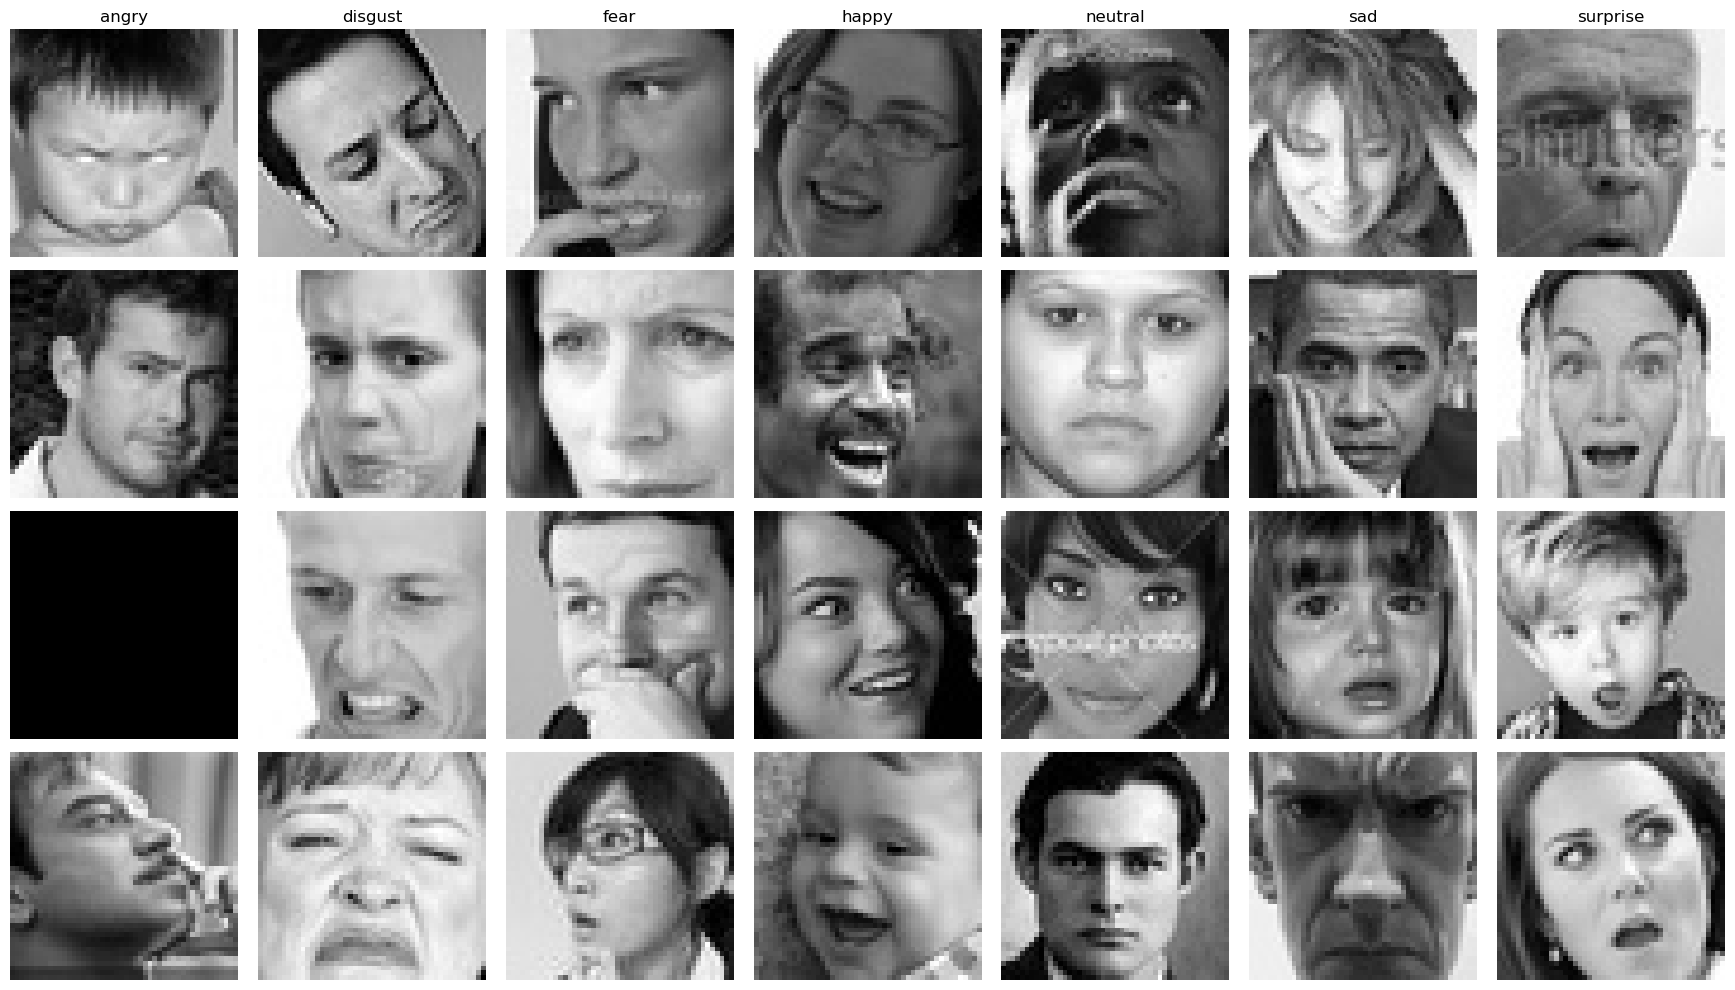

In [26]:
def get_example_paths_per_class(dataset_root=DATASET_ROOT, split="train",
                                emotions=EMOTIONS, n_examples=3):
    examples = {}

    for emo in emotions:
        folder = os.path.join(dataset_root, split, emo)
        if not os.path.isdir(folder):
            print(f"[WARN] Ordner existiert nicht: {folder}")
            continue

        img_files = [f for f in os.listdir(folder)
                     if f.lower().endswith((".png", ".jpg", ".jpeg"))]

        if len(img_files) == 0:
            print(f"[WARN] Keine Bilder in: {folder}")
            continue

        chosen = img_files[:n_examples]  # oder np.random.choice
        examples[emo] = [os.path.join(folder, f) for f in chosen]

    return examples


def plot_examples_grid(examples_dict, grayscale=True):
    emotions = list(examples_dict.keys())
    n_classes = len(emotions)              # 7 Spalten
    n_examples = len(next(iter(examples_dict.values())))  # 3 Zeilen

    plt.figure(figsize=(n_classes * 2.5, n_examples * 2.5))

    for col, emo in enumerate(emotions):
        paths = examples_dict[emo]

        for row, path in enumerate(paths):
            img = cv2.imread(path)
            if grayscale:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Position im Grid bestimmen
            plt.subplot(n_examples, n_classes, row * n_classes + col + 1)
            plt.imshow(img, cmap="gray" if grayscale else None)
            plt.axis("off")

            # Spaltentitel nur in der ersten Zeile
            if row == 0:
                plt.title(emo, fontsize=12)

    plt.tight_layout()
    plt.show()


# Beispielaufruf
examples = get_example_paths_per_class(split="train", n_examples=4)
plot_examples_grid(examples)

<h3> Durchschnittliche Helligkeit pro Klasse

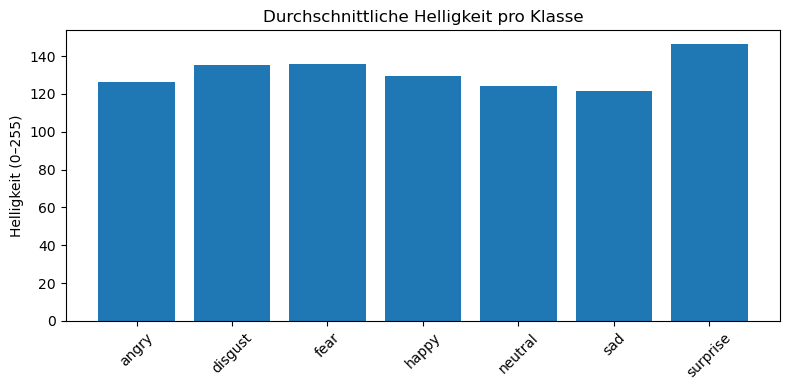

In [27]:
def avg_brightness_per_class(dataset_root=DATASET_ROOT, split="train", emotions=EMOTIONS):
    brightness = {}

    for emo in emotions:
        folder = os.path.join(dataset_root, split, emo)
        values = []

        for fname in os.listdir(folder):
            if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                img = cv2.imread(os.path.join(folder, fname), cv2.IMREAD_GRAYSCALE)
                values.append(np.mean(img))

        brightness[emo] = np.mean(values)

    plt.figure(figsize=(8,4))
    plt.bar(brightness.keys(), brightness.values())
    plt.title("Durchschnittliche Helligkeit pro Klasse")
    plt.ylabel("Helligkeit (0–255)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

avg_brightness_per_class()


<h2> AffectNet Dataset analysieren

In [ ]:
AFFECTNET_ROOT = "../Raw Data/AffectNet"
SPLITS_AFF = ["Train", "Test"]

AFFECTNET_LABELS = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

<h3> Anzahl der Bilder pro Klasse

[INFO] Label 'contempt' (normalized='contempt') nicht in target_labels – skippe.
[INFO] Label 'Contempt' (normalized='contempt') nicht in target_labels – skippe.
=== Gesamtanzahl Bilder pro Klasse (AffectNet, Train+Test) ===
angry    : 3218
disgust  : 2477
fear     : 3176
happy    : 5044
neutral  : 5126
sad      : 4675
surprise : 4039

Gesamtanzahl Bilder: 27755


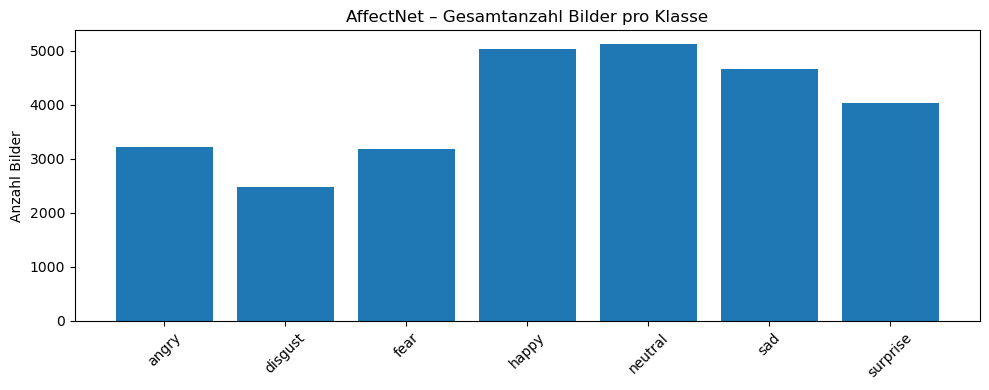

In [8]:
def normalize_affectnet_label(folder_name: str) -> str:
    """
    Mappt Ordnernamen auf ein einheitliches Label.
    z.B. 'Anger'/'anger' -> 'angry'
    """
    name = folder_name.lower()
    if name == "anger":
        return "angry"
    return name


def count_affectnet_images(dataset_root=AFFECTNET_ROOT,
                           splits=SPLITS_AFF,
                           target_labels=AFFECTNET_LABELS):
    total_counts = defaultdict(int)

    for split in splits:
        split_dir = os.path.join(dataset_root, split)
        if not os.path.isdir(split_dir):
            print(f"[WARN] Split-Ordner existiert nicht: {split_dir}")
            continue

        for folder in os.listdir(split_dir):
            folder_path = os.path.join(split_dir, folder)
            if not os.path.isdir(folder_path):
                continue

            label = normalize_affectnet_label(folder)

            if label not in target_labels:
                print(f"[INFO] Label '{folder}' (normalized='{label}') nicht in target_labels – skippe.")
                continue

            for fname in os.listdir(folder_path):
                if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                    total_counts[label] += 1

    # Werte in fixer Reihenfolge
    counts_list = [total_counts[lbl] for lbl in target_labels]

    # Print
    print("=== Gesamtanzahl Bilder pro Klasse (AffectNet, Train+Test) ===")
    for lbl in target_labels:
        print(f"{lbl:9s}: {total_counts[lbl]}")
    print("\nGesamtanzahl Bilder:", sum(counts_list))

    # Plot
    x = np.arange(len(target_labels))
    plt.figure(figsize=(10, 4))
    plt.bar(x, counts_list)
    plt.xticks(x, target_labels, rotation=45)
    plt.ylabel("Anzahl Bilder")
    plt.title("AffectNet – Gesamtanzahl Bilder pro Klasse")
    plt.tight_layout()
    plt.show()

    return total_counts


# Aufruf
affectnet_counts = count_affectnet_images()

<h3> Pixel pro Bild

In [ ]:
def all_affectnet_images_are_96x96(dataset_root=AFFECTNET_ROOT):
    for split in SPLITS_AFF:
        split_path = os.path.join(dataset_root, split)
        if not os.path.isdir(split_path):
            continue

        for clazz in os.listdir(split_path):
            class_dir = os.path.join(split_path, clazz)
            if not os.path.isdir(class_dir):
                continue

            for fname in os.listdir(class_dir):
                if not fname.lower().endswith((".png", ".jpg", ".jpeg")):
                    continue

                path = os.path.join(class_dir, fname)
                img = cv2.imread(path)

                if img is None:
                    return False

                h, w = img.shape[:2]
                if w != 96 or h != 96:
                    return False

    return True

# Ergebnis ausgeben
if all_affectnet_images_are_96x96():
    print("Alle Bilder sind 96 x 96 Pixel groß")
else:
    print("Nicht alle Bilder sind 96 x 96 Pixel groß")


Alle Bilder sind 96 x 96 Pixel groß


<h3> Beispielbilder pro Klasse

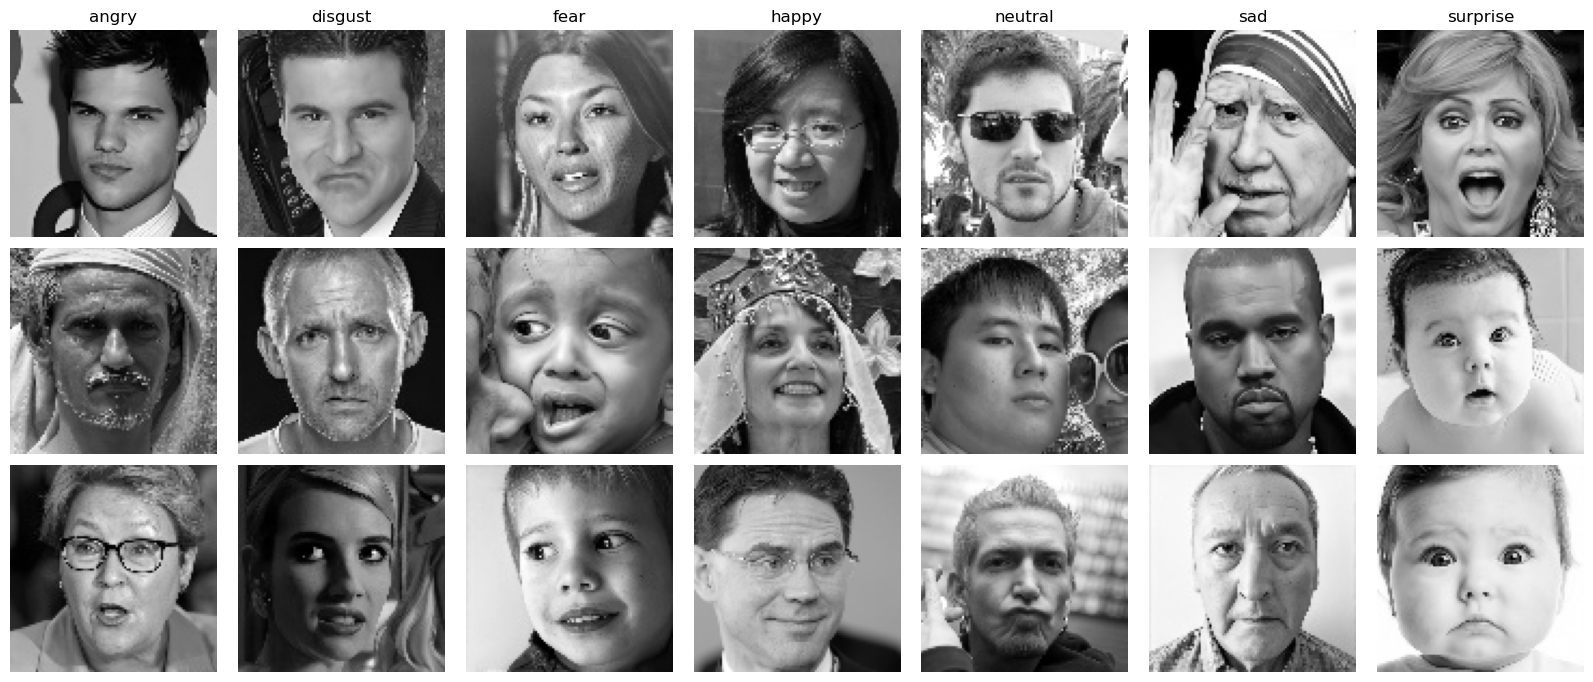

In [15]:
# Deine 7 Ziel-Emotionen
EMOTIONS_7 = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

def normalize_affectnet_label(folder_name: str) -> str:
    """Normalisiere AffectNet Klassen auf Zieldateinamen."""
    name = folder_name.lower()

    if name == "anger":
        return "angry"
    return name


def get_affectnet_examples(dataset_root=AFFECTNET_ROOT, split="Train", n_examples=3):
    examples = {emo: [] for emo in EMOTIONS_7}

    split_path = os.path.join(dataset_root, split)

    for folder in os.listdir(split_path):
        class_dir = os.path.join(split_path, folder)
        if not os.path.isdir(class_dir):
            continue

        label = normalize_affectnet_label(folder)

        # nur die 7 Hauptemotionen, contempt skippen
        if label not in EMOTIONS_7:
            continue

        files = [f for f in os.listdir(class_dir)
                 if f.lower().endswith((".png", ".jpg", ".jpeg"))]

        if len(files) == 0:
            continue

        chosen = files[:n_examples]

        examples[label] = [os.path.join(class_dir, f) for f in chosen]

    return examples


def plot_examples_affectnet(examples, grayscale=True):
    emotions = EMOTIONS_7                 # in fixer Reihenfolge
    n_classes = len(emotions)             # 7
    n_examples = 3                        # 3 Reihen

    plt.figure(figsize=(n_classes * 2.3, n_examples * 2.3))

    for col, emo in enumerate(emotions):
        paths = examples[emo]

        for row, path in enumerate(paths):

            img = cv2.imread(path)
            if img is None:
                continue

            if grayscale:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.subplot(n_examples, n_classes, row * n_classes + col + 1)
            plt.imshow(img, cmap="gray" if grayscale else None)
            plt.axis("off")

            # Titel nur oben
            if row == 0:
                plt.title(emo, fontsize=12)

    plt.tight_layout()
    plt.show()


# ========== AUSFÜHREN ==========
examples_affectnet = get_affectnet_examples(split="Train", n_examples=3)
plot_examples_affectnet(examples_affectnet)

<h3> Durchschnittliche Helligkeit pro Klasse

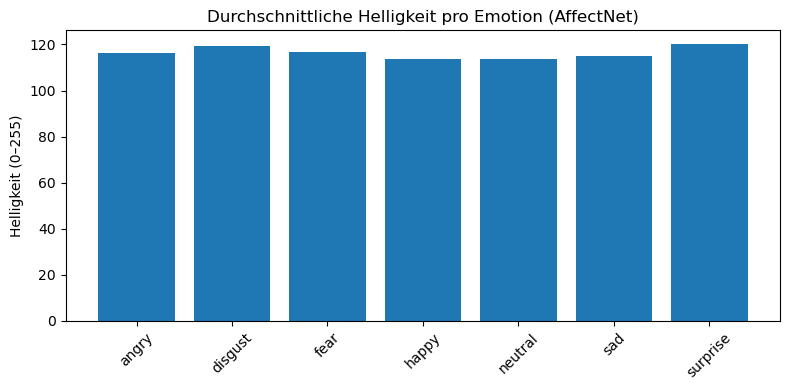

{'angry': np.float64(116.18731808733212),
 'disgust': np.float64(119.47420167450265),
 'fear': np.float64(116.90972820103686),
 'happy': np.float64(113.56518414858961),
 'neutral': np.float64(113.52083204208799),
 'sad': np.float64(115.08189869745246),
 'surprise': np.float64(120.11783335675943)}

In [16]:
def normalize_affectnet_label(folder_name: str) -> str:
    name = folder_name.lower()

    if name == "anger":
        return "angry"
    if name == "contempt":
        return "contempt"  # wird ignoriert
    return name


def compute_mean_brightness_affectnet(dataset_root=AFFECTNET_ROOT,
                                      splits=SPLITS,
                                      emotions=EMOTIONS_7):
    brightness = {emo: [] for emo in emotions}

    for split in splits:
        split_path = os.path.join(dataset_root, split)

        for folder in os.listdir(split_path):
            class_path = os.path.join(split_path, folder)
            if not os.path.isdir(class_path):
                continue

            label = normalize_affectnet_label(folder)

            # nur 7 Klassen, contempt skippen
            if label not in emotions:
                continue

            files = [f for f in os.listdir(class_path)
                     if f.lower().endswith((".png", ".jpg", ".jpeg"))]

            for fname in files:
                fpath = os.path.join(class_path, fname)
                img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)

                if img is None:
                    continue

                brightness[label].append(np.mean(img))

    # Mittelwert je Klasse
    mean_brightness = {emo: np.mean(values) for emo, values in brightness.items()}

    # Plotten
    plt.figure(figsize=(8,4))
    plt.bar(mean_brightness.keys(), mean_brightness.values())
    plt.title("Durchschnittliche Helligkeit pro Emotion (AffectNet)")
    plt.ylabel("Helligkeit (0–255)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return mean_brightness


# --- AUSFÜHREN ---
mean_brightness_affectnet = compute_mean_brightness_affectnet()
mean_brightness_affectnet

<h1> Datasets kombinieren